Inspired by https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version 

# Imports

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from keras.preprocessing import text, sequence
import torch.utils.data as data

from gensim.models.fasttext import FastText

# import fasttext
from gensim.models.fasttext import FastText
from utils import seed_everything, preprocess, build_matrix, EmbeddingFastText
from evaluation import compute_bias_metrics_for_model, get_final_metric
from train import train
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
random_state = 42

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
seed_everything(random_state)

In [16]:
data_folder = '/nmnt/media/home/farshov/vk_data/'
GLOVE_EMBEDDING_PATH = '/nmnt/media/home/farshov/embeddings/crawl-300d-2M.vec'

# Data Loading

In [17]:
train = pd.read_csv(data_folder + 'train.csv')
test = pd.read_csv(data_folder + 'test.csv')

In [18]:
print(train.shape)
train.head(3)

(1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [19]:
print(test.shape)
test.head(3)

(97320, 2)


,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...


Prediction will be made only by comment

# Data Analysis

In [20]:
target_columns = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

In [21]:
train[target_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 6 columns):
target             float64
severe_toxicity    float64
obscene            float64
identity_attack    float64
insult             float64
threat             float64
dtypes: float64(6)
memory usage: 82.6 MB


In [22]:
train[target_columns].describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


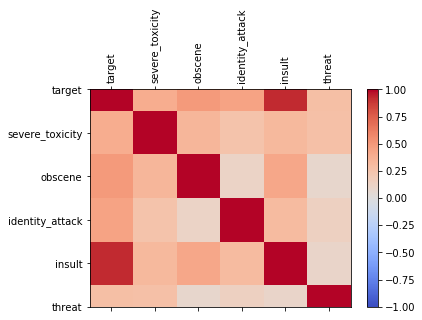

In [23]:
data = train[target_columns]
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

#### It seems like insults is the most common type of toxic comments in the Internet, it has a sence

# Data processing

In [37]:
x_train = preprocess(train['comment_text'])
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

In [38]:
# tokenizer = text.Tokenizer()
# tokenizer.fit_on_texts(list(x_train) + list(x_test))

# x_train = tokenizer.texts_to_sequences(x_train)
# x_test = tokenizer.texts_to_sequences(x_test)

In [39]:
x_train = x_train.apply(lambda x: x.split())
x_test = x_test.apply(lambda x: x.split())

In [40]:
lenghts_train = [len(com) for com in x_train]
lenghts_test = [len(com) for com in x_test]
# lenghts_train and lenghts_test will be used in RNN
lenghts = lenghts_train + lenghts_test
print('median:', np.median(lenghts))
print('mean:', np.mean(lenghts))
print('max:', np.max(lenghts))
print('min:', np.min(lenghts))

median: 36.0
mean: 52.87058680660332
max: 323
min: 0


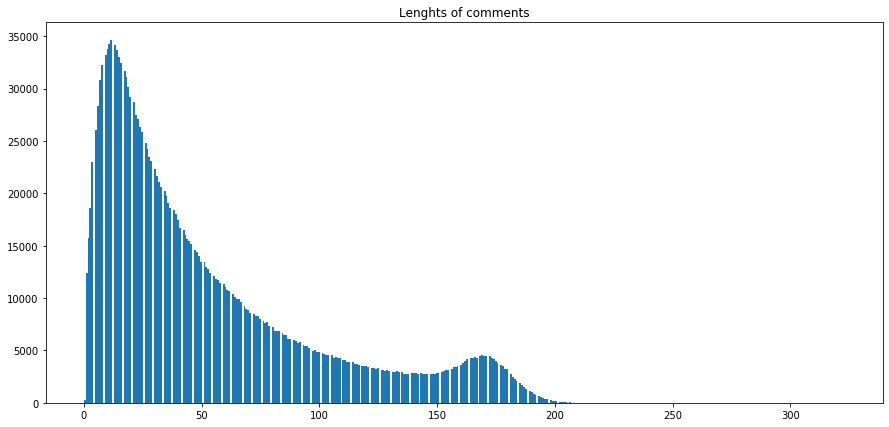

In [41]:
plt.figure(figsize=(15, 7))
plt.hist(lenghts, bins=400)  # arguments are passed to np.histogram
plt.title("Lenghts of comments")
plt.show()

#### The most of all comments has less than 200 symbols, let's use this number for padding and truncating

In [42]:
MAX_SEN_LEN = 200

In [27]:
# x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEN_LEN, padding='post', truncating='post')
# x_test = sequence.pad_sequences(x_test, maxlen=MAX_SEN_LEN, padding='post', truncating='post')

In [46]:
# max_features = None
# max_features = max_features or len(tokenizer.word_index) + 1
# max_features

In [47]:
# gc.collect()

In [45]:
# glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
# print('n unknown words (glove): ', len(unknown_words_glove))

#### It seems that using of fast text will be the best, because in Internet comments people often use short forms of words, slang and etc. All this stuff will be out-of-bag cases, but fasttext works with n-grams. So I think that it will perform better encoding ow texts

In [ ]:
embedder = FastText(size=100, window=5, min_count=5, workers=12)
embedder.build_vocab(list(x_train) + list(x_test))
embedder.train(list(x_train) + list(x_test), total_examples=embedder.corpus_count, epochs=100)

In [ ]:
embedder.wv['cat']
embedder.wv['cats']

In [ ]:
embedding.save("~/vk_models/fast_text")
# model = FastText.load("~/vk_models/fast_text")

In [ ]:
gc.collect()

# Training

In [ ]:
y_train = np.hstack([y_train[:, np.newaxis], y_aux_train])
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test)

model = RNNClassifier(embedding, emb_size=100, hidden_size=100, num_layers=2, num_aux=y_aux_train.shape[-1])

test_preds = train(model, train_dataset, test_dataset, output_dim=y_train_torch.shape[-1], 
                         loss_fn=nn.BCEWithLogitsLoss(reduction='mean'))

# Evaluation

From Benchmark kernel

In [29]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)

MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

NameError: name 'compute_bias_metrics_for_model' is not defined

# Submission

In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)